# Required libraries and installation

In [ ]:
# capture is put to not see the long output
%%capture 

# Install GDAL, Geopandas, kaleido to save images
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install geopy
!pip install plotly_express
!pip install ipython-autotime
!pip install kaleido # to write images
!pip install plotly>=4.0.0 # bcz write_image didnt work
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
!pip install pandasql # sql
!pip install "dask[dataframe]"

In [ ]:
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import time 
from dask import dataframe as dd
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import requests
from time import time
import plotly_express as px
#pytorch
import torch
from torch import nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
#tensorflow
import tensorflow as tf
import PIL
import PIL.Image
import pathlib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Combining the monthly traffic data from the website
--------------

1. Getting the url of all the files ending with `.zip` from the Madrid data website.

In [ ]:
# Creating a new file to store the zip file links
newfile = open('zipfiles.txt','w')

#Set variable for page to be opened and url to be concatenated 
page =requests.get('https://datos.madrid.es/sites/v/index.jsp?vgnextoid=33cb30c367e78410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD')
baseurl= 'https://datos.madrid.es/egob/catalogo/'

#Use BeautifulSoup to clean up the page
soup = BeautifulSoup(page.content)
soup.prettify()

#Find all the links on the page that end in .zip and write them into the text file
for anchor in soup.findAll('a', href=True): # find all href urls
    links = anchor['href']
    if links.endswith('.zip'): # only getting the lınks ends with .zip
        newfile.write(links + '\n') # writing the new file link into the next row
newfile.close()

2. Appending the first 5 months data into a dataframe called `df_traffic`.

In [ ]:
# download from web
baseurl= 'https://datos.madrid.es'

# empty data frame to append all the extracted files
df_traffic = pd.DataFrame()

start_time = time()
with open("zipfiles.txt") as file: 
  for i in range(2): # the last 9 most recent months' files only
    line = next(file).strip()
    url = baseurl+line
    content = requests.get(url)

    # unzip the content
    zip_file  = ZipFile(BytesIO(content.content))
    print(zip_file.namelist())
    
    start = time()
    for text_file in zip_file.infolist():

      # 1. Opening each zip file and extracting the csv
      df = pd.read_csv(zip_file.open(text_file.filename), delimiter=';', header=0)
      #df = df[['id', 'fecha', 'tipo_elem', 'intensidad', 'vmed']]
      print(df.isnull().sum())
      print(len(df))
      #df.drop("column_name", axis=1, inplace=True)
      # 2. Changing the fecha data type to datetime
      # df['fecha'] = pd.to_datetime(df['fecha']).astype("M8[us]")
      
      #########################################################################

      ######### Filtering options-Hourly or certain time of the day ###########
      # Aggregating into hour frequency
      # df_hourly = df.groupby([pd.Grouper(freq='H', key='fecha'), 'id']).mean().reset_index()
      # # Splitting the fecha datetime column into date and hour columns
      # df_hourly['hour'] = df_hourly['fecha'].dt.hour
      # df_hourly['date'] = df_hourly['fecha'].dt.date
    
      # 3. Filtering 10 in the morning and 15 minutes after for output - Chosen hour: 10 in the morning
      #df_hourly = df[((df['fecha'].dt.hour == 10) & (df['fecha'].dt.minute == 0))|
      #               ((df['fecha'].dt.hour == 10) & (df['fecha'].dt.minute == 15))]
     
      #df_hourly['date'] = df_hourly['fecha'].dt.date
      #print(df_hourly.head(4))
      #df['date'] = df['fecha'].dt.date
      print(df.head(4))
      #########################################################################
      
      # Final - Concatenating all the processed monthly sensor data into df_traffic
      df_traffic = pd.concat([df_traffic, df]) #df_hourly
    print(f'The number of rows processed')  
    print(f'Time consumed for operating the monthly traffic data (second): ', time()-start)
    print("") #space

end_time = time()
print(df_traffic.info())
print(f'Total Time consumed (second): ',end_time-start_time)

['06-2022.csv']
id                         0
fecha                      0
tipo_elem                  0
intensidad                 0
ocupacion              19802
carga                      0
vmed                       0
error                      0
periodo_integracion        0
dtype: int64
11399709
     id                fecha tipo_elem  intensidad  ocupacion  carga  vmed  \
0  1001  2022-06-01 00:00:00       M30         612        2.0      0    61   
1  1001  2022-06-01 00:15:00       M30         612        1.0      0    62   
2  1001  2022-06-01 00:30:00       M30         492        1.0      0    58   
3  1001  2022-06-01 00:45:00       M30         348        1.0      0    58   

  error  periodo_integracion  
0     N                    5  
1     N                    5  
2     N                    5  
3     N                    5  
The number of rows processed
Time consumed for operating the monthly traffic data (second):  16.336912155151367

['05-2022.csv']
id                        

In [ ]:
zip_file.open(text_file.filename)

<zipfile.ZipExtFile name='06-2022.csv' mode='r' compress_type=deflate>

In [ ]:
df_traffic.rename(columns = {'fecha' : 'long_date', 'tipo_elem' : 'elem_type',
                                          'intensidad' : 'intensity','ocupacion' : 'occupation',
                                          'carga' : 'charge','periodo_integracion' : 'integration_period',}, inplace = True)

df_traffic

,id,long_date,elem_type,intensity,occupation,charge,vmed,error,integration_period,date
40,1001,2022-06-01 10:00:00,M30,3528,10.0,0,60.0,N,5,2022-06-01
41,1001,2022-06-01 10:15:00,M30,2880,11.0,0,59.0,N,5,2022-06-01
136,1001,2022-06-02 10:00:00,M30,3504,10.0,0,58.0,N,5,2022-06-02
137,1001,2022-06-02 10:15:00,M30,3000,9.0,0,58.0,N,5,2022-06-02
232,1001,2022-06-03 10:00:00,M30,2088,7.0,0,60.0,N,5,2022-06-03
...,...,...,...,...,...,...,...,...,...,...
12036668,10867,2021-10-29 10:15:00,URB,123,2.0,11,0.0,N,15,2021-10-29
12036763,10867,2021-10-30 10:00:00,URB,53,10.0,14,0.0,N,15,2021-10-30
12036764,10867,2021-10-30 10:15:00,URB,96,3.0,9,0.0,N,15,2021-10-30
12036857,10867,2021-10-31 10:00:00,URB,56,2.0,5,0.0,N,15,2021-10-31


In [ ]:
df_traffic_9 = df_traffic[['id', 'long_date','date','intensity','vmed']]

As extracting all the monthly traffic data from the website and appending them is a time consuming process, I am going to store the `df_traffic` to my drive by writing the data frame into a `csv` file.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

df_traffic_9.to_csv(r'/content/drive/My Drive/THESIS/nine_month_traffic_data.csv', index = False, header=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----------------------
## Data preprocessing

### Description of the data set
- First dataset - Traffic Intensity\
On the below visual, the detailed description of each variable in the data can be found:

----
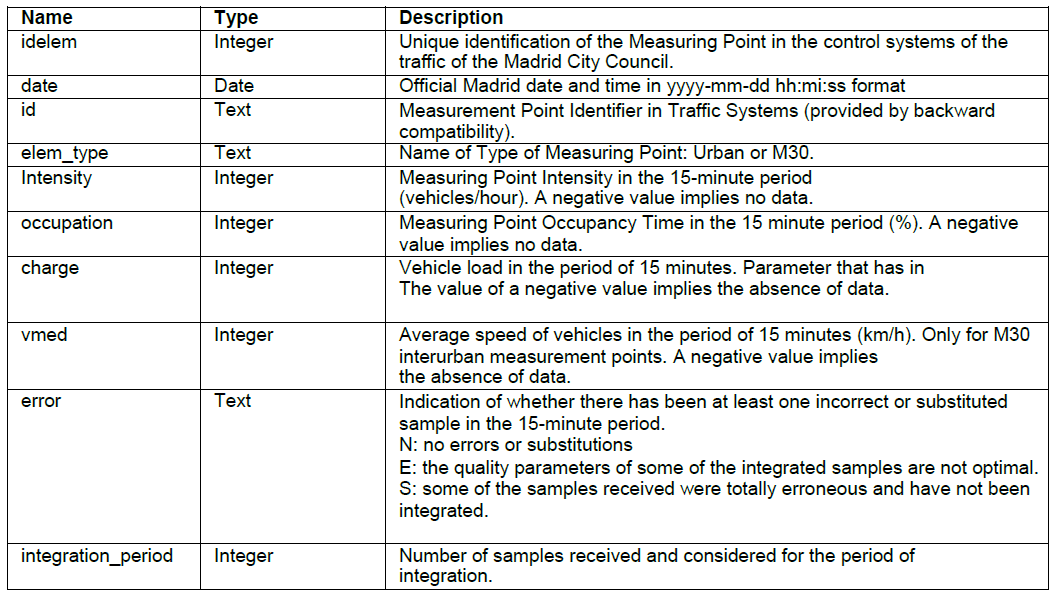

The data `df_traffic` is a day-ahead traffic data of Madrid city from February 2022 to November 2021. The data set contains minute time series data which has observations on every 15 minutes from 2022-01-01 to 2021-10-31 for 368 zones (id) in Madrid.

## Reading the data from drive to dask data frame and changing to hour frequency..

In [ ]:
"""
start = time.time()
trafficMAD = dd.read_csv('/content/drive/MyDrive/THESIS/all_traffic_data.csv')
end = time.time()
print("Read csv with dask: ",(end-start),"sec")
trafficMAD.head(5)

Read csv with dask:  0.5770635604858398 sec


,id,long_date,elem_type,intensity,occupation,charge,vmed,error,integration_period
0,1001,2022-02-01 00:00:00,M30,2400,9.0,0,53.0,N,5
1,1001,2022-02-01 00:15:00,M30,2400,9.0,0,53.0,N,5
2,1001,2022-02-01 00:30:00,M30,2400,9.0,0,53.0,N,5
3,1001,2022-02-01 00:45:00,M30,2400,9.0,0,53.0,N,5
4,1001,2022-02-01 01:00:00,M30,2400,9.0,0,53.0,N,5


As there are 59324232 observations for the extracted 5 months, the minute frequency will be changed to hourly in order to reduce the data complexity.

In [ ]:
trafficMAD1 = trafficMAD[['id', 'elem_type','long_date','intensity','vmed']]
trafficMAD1

,id,elem_type,long_date,intensity,vmed
npartitions=45,,,,,
,int64,object,object,int64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


First, I am going to work with a small size data frame in order to process fast.

In [ ]:
small_df = trafficMAD.head(1000000)

In [ ]:
small_df['long_date'] = dd.to_datetime(small_df['long_date']).astype("M8[us]")
trafficMAD1 = small_df.groupby([pd.Grouper(freq='H', key='long_date'), 'id']).mean().reset_index()
trafficMAD1

,long_date,id,intensity,occupation,charge,vmed,integration_period
0,2022-02-01 00:00:00,1001,2400.00,9.00,0.00,53.0,5.0
1,2022-02-01 00:00:00,1002,2340.00,9.00,0.00,64.0,5.0
2,2022-02-01 00:00:00,1003,3300.00,14.00,0.00,62.0,5.0
3,2022-02-01 00:00:00,1006,2160.00,6.00,0.00,69.0,5.0
4,2022-02-01 00:00:00,1009,1980.00,4.00,0.00,64.0,5.0
...,...,...,...,...,...,...,...
253291,2022-02-28 23:00:00,3782,95.00,1.00,8.50,0.0,13.5
253292,2022-02-28 23:00:00,3783,217.25,1.25,14.00,0.0,15.0
253293,2022-02-28 23:00:00,3784,138.75,0.25,6.50,0.0,13.5
253294,2022-02-28 23:00:00,3785,277.75,31.25,26.75,0.0,13.5


In [ ]:
print(trafficMAD1.shape)
type(trafficMAD1)

(253296, 7)


pandas.core.frame.DataFrame

# **Reading the location information data and merging by id**

In [ ]:
trafficMAD = pd.read_csv('/content/drive/MyDrive/THESIS/9_months/nine_month_traffic_data.csv')
locationMAD = pd.read_csv('/content/drive/MyDrive/THESIS/pmed_ubicacion_01-2022.csv')
locationMAD.head(5)

,elem_type,district,id,cod_cent,name,utm_x,utm_y,longitude,latitude
0,URB,4.0,3840,1001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.3433,4475767.942,-3.688323,40.430502
1,URB,4.0,3841,1002,Jose Ortega y Gasset O-E - Serrano-Pº Castellana,441705.8823,4475769.687,-3.687256,40.430524
2,URB,1.0,3842,1003,Pº Recoletos N-S - Almirante-Prim,441319.3713,4474841.154,-3.691727,40.422132
3,URB,4.0,3843,1004,Pº Recoletos S-N - Pl. Cibeles- Recoletos,441301.6330,4474763.728,-3.691929,40.421433
4,URB,4.0,3844,1005,(AFOROS) Pº Castellana S-N - Eduardo Dato - P...,441605.7651,4476132.139,-3.688470,40.433782


In [ ]:
new_locationMAD = locationMAD[locationMAD.id != 6637]
new_locationMAD['district'] = new_locationMAD['district'].fillna(6)
new_locationMAD.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


elem_type      0
district       0
id             0
cod_cent       0
name          25
utm_x        257
utm_y        257
longitude    257
latitude     257
dtype: int64

In [ ]:
print(trafficMAD.head(4))
print("")
print('Missing values: ')
print(trafficMAD.isnull().sum())
print("")
print('Intensity value of vmed missing values: ',trafficMAD[trafficMAD['vmed'].isnull()]['intensity'].unique())
print("")
print('Is there any zero values also in intensity, when vmed is zero? ')
print(trafficMAD[trafficMAD['vmed']==0]['intensity'].unique())

In [ ]:
#trafficMAD = trafficMAD.iloc[: , :-1]

After doing some data manipulations in the first dataset, here, the modified time series will be merged by id column with the second dataset which has the location information of each id.

In [ ]:
merged_trafficMAD = pd.merge(trafficMAD.iloc[: , :-1], # removing the vmed column as it has missing values
                             new_locationMAD[['id', 'district', 'name','longitude', 'latitude']], 
                             on=["id"])

print(f'The shape of the merged data {merged_trafficMAD.shape}')
merged_trafficMAD.info()
print(merged_trafficMAD.isnull().sum())
#merged_trafficMAD.to_csv(r'/content/drive/My Drive/THESIS/merged_trafficMAD.csv', index = False, header=True)
merged_trafficMAD.head(5)

The shape of the merged data (2216317, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216317 entries, 0 to 2216316
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   long_date  object 
 2   date       object 
 3   intensity  int64  
 4   district   float64
 5   name       object 
 6   longitude  float64
 7   latitude   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 152.2+ MB
id                0
long_date         0
date              0
intensity         0
district          0
name           6363
longitude    134488
latitude     134488
dtype: int64


,id,long_date,date,intensity,district,name,longitude,latitude
0,1001,2022-06-01 10:00:00,2022-06-01,3528,10.0,05FT10PM01,-3.740786,40.409729
1,1001,2022-06-01 10:15:00,2022-06-01,2880,10.0,05FT10PM01,-3.740786,40.409729
2,1001,2022-06-02 10:00:00,2022-06-02,3504,10.0,05FT10PM01,-3.740786,40.409729
3,1001,2022-06-02 10:15:00,2022-06-02,3000,10.0,05FT10PM01,-3.740786,40.409729
4,1001,2022-06-03 10:00:00,2022-06-03,2088,10.0,05FT10PM01,-3.740786,40.409729


Dropping the missing values and printing the new data frame info:

In [ ]:
merged_trafficMAD.dropna(inplace=True)
merged_trafficMAD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073877 entries, 0 to 2216862
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   long_date  object 
 2   date       object 
 3   intensity  int64  
 4   district   float64
 5   name       object 
 6   longitude  float64
 7   latitude   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 142.4+ MB


Changing the district column type to integer:

In [ ]:
merged_trafficMAD

,id,long_date,date,intensity,district,name,longitude,latitude
0,1001,2022-06-01 10:00:00,2022-06-01,3528,10.0,05FT10PM01,-3.740786,40.409729
1,1001,2022-06-01 10:15:00,2022-06-01,2880,10.0,05FT10PM01,-3.740786,40.409729
2,1001,2022-06-02 10:00:00,2022-06-02,3504,10.0,05FT10PM01,-3.740786,40.409729
3,1001,2022-06-02 10:15:00,2022-06-02,3000,10.0,05FT10PM01,-3.740786,40.409729
4,1001,2022-06-03 10:00:00,2022-06-03,2088,10.0,05FT10PM01,-3.740786,40.409729
...,...,...,...,...,...,...,...,...
2216312,10000,2021-10-30 10:00:00,2021-10-30,15,9.0,(TACTICO) SALIDA POLICIA,-3.729480,40.428967
2216313,10000,2021-10-30 10:15:00,2021-10-30,24,9.0,(TACTICO) SALIDA POLICIA,-3.729480,40.428967
2216314,10000,2021-10-31 10:00:00,2021-10-31,15,9.0,(TACTICO) SALIDA POLICIA,-3.729480,40.428967
2216315,10000,2021-10-31 10:15:00,2021-10-31,60,9.0,(TACTICO) SALIDA POLICIA,-3.729480,40.428967


In [ ]:
merged_trafficMAD['long_date'] = pd.to_datetime(merged_trafficMAD['long_date']).astype("M8[us]")

# Filtering the 15 minutes after data in order to prepare the y output

y_trafficMAD = merged_trafficMAD[merged_trafficMAD['long_date'].dt.minute == 15]
y_trafficMAD

,id,long_date,date,intensity,district,name,longitude,latitude
1,1001,2022-06-01 10:15:00,2022-06-01,2880,10.0,05FT10PM01,-3.740786,40.409729
3,1001,2022-06-02 10:15:00,2022-06-02,3000,10.0,05FT10PM01,-3.740786,40.409729
5,1001,2022-06-03 10:15:00,2022-06-03,2388,10.0,05FT10PM01,-3.740786,40.409729
7,1001,2022-06-04 10:15:00,2022-06-04,2100,10.0,05FT10PM01,-3.740786,40.409729
9,1001,2022-06-05 10:15:00,2022-06-05,1452,10.0,05FT10PM01,-3.740786,40.409729
...,...,...,...,...,...,...,...,...
2216307,10000,2021-10-27 10:15:00,2021-10-27,15,9.0,(TACTICO) SALIDA POLICIA,-3.729480,40.428967
2216309,10000,2021-10-28 10:15:00,2021-10-28,15,9.0,(TACTICO) SALIDA POLICIA,-3.729480,40.428967
2216311,10000,2021-10-29 10:15:00,2021-10-29,20,9.0,(TACTICO) SALIDA POLICIA,-3.729480,40.428967
2216313,10000,2021-10-30 10:15:00,2021-10-30,24,9.0,(TACTICO) SALIDA POLICIA,-3.729480,40.428967


**Visualizing each sensor and their intensity in the map**

Filtering each sensor by the district:

In [ ]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## query1
q = """SELECT district, count(*)
       FROM merged_trafficMAD
       GROUP BY district;"""

pysqldf(q)

,district,count(*)
0,1.0,77709
1,2.0,130423
2,3.0,73294
3,4.0,104413
4,5.0,161931
5,6.0,126885
6,7.0,70685
7,8.0,241213
8,9.0,144366
9,10.0,124868


In total there are 21 district areas.

In [ ]:
# query2
q = """SELECT district,date, AVG(latitude) as lat, AVG(longitude) as lon, AVG(intensity) as intensity
       FROM merged_trafficMAD
       GROUP BY district,date;"""

district_id = pysqldf(q)

In [ ]:
district_id

,district,date,lat,lon,intensity
0,1.0,2021-10-01,40.417150,-3.707503,591.058824
1,1.0,2021-10-02,40.417150,-3.707504,414.245675
2,1.0,2021-10-03,40.417229,-3.707497,261.650519
3,1.0,2021-10-04,40.417161,-3.707455,570.710345
4,1.0,2021-10-05,40.417114,-3.707492,602.613240
...,...,...,...,...,...
5726,21.0,2022-06-26,40.464303,-3.593532,158.758621
5727,21.0,2022-06-27,40.464121,-3.593729,262.438596
5728,21.0,2022-06-28,40.464293,-3.593679,252.438596
5729,21.0,2022-06-29,40.464124,-3.593728,233.473684


In [ ]:
# query3 - getting the average intensity of 15 minutes after for each observed day of the district:

q = """SELECT district, date, AVG(intensity) as intensity
       FROM y_trafficMAD
       GROUP BY district,date;"""

y_district_date = pysqldf(q)

In [ ]:
y_district_date

,district,date,intensity
0,1.0,2021-10-01,565.441379
1,1.0,2021-10-02,402.097222
2,1.0,2021-10-03,268.124138
3,1.0,2021-10-04,564.506944
4,1.0,2021-10-05,598.979021
...,...,...,...
5726,21.0,2022-06-26,158.413793
5727,21.0,2022-06-27,249.428571
5728,21.0,2022-06-28,233.172414
5729,21.0,2022-06-29,226.000000


Filtering the district that will be estimated later. The chosen district is 14. So I will filter the 14th district only. Later on the number of district could be increased.

In [ ]:
y_district_date = y_district_date[y_district_date['district']==14][['date','intensity']]
y_district_date

,date,intensity
3549,2021-10-01,658.613861
3550,2021-10-02,524.690000
3551,2021-10-03,322.850000
3552,2021-10-04,733.464646
3553,2021-10-05,672.434343
...,...,...
3817,2022-06-26,197.806818
3818,2022-06-27,380.636364
3819,2022-06-28,433.102273
3820,2022-06-29,391.431818


Saving the output average intensity of the district 14:

In [ ]:
y_district_date.to_csv(r'/content/drive/My Drive/THESIS/9_months/y_district14_9months_new.csv', index = False, header=True)

## **Intensity visuals**

Writing the visuals into the drive images section.

In [ ]:
date_names = merged_trafficMAD['date'].unique()
len(date_names)

273

In [ ]:
# normalize the dataset
# make a copy of dataframe
from sklearn.preprocessing import MinMaxScaler
scaled_features = district_id.copy()

col_names = ['intensity']
features = scaled_features[col_names]

# Use scaler of choice; here Standard scaler is used
scaler = MinMaxScaler(feature_range=(0, 1)).fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features

In [ ]:
scaled_features

,district,date,lat,lon,intensity
0,1.0,2021-10-01,40.417150,-3.707503,0.475943
1,1.0,2021-10-02,40.417150,-3.707504,0.318204
2,1.0,2021-10-03,40.417229,-3.707497,0.182070
3,1.0,2021-10-04,40.417161,-3.707455,0.457789
4,1.0,2021-10-05,40.417114,-3.707492,0.486251
...,...,...,...,...,...
5726,21.0,2022-06-26,40.464303,-3.593532,0.090278
5727,21.0,2022-06-27,40.464121,-3.593729,0.182773
5728,21.0,2022-06-28,40.464293,-3.593679,0.173852
5729,21.0,2022-06-29,40.464124,-3.593728,0.156933


In [ ]:
px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")

for date in date_names:
# fig = px.scatter_mapbox(district_id[district_id['date']==date], 
#                             lat='lat', lon='lon',  zoom=10,hover_name="district", hover_data=["district", "intensity"], 
#                             color="intensity",size="intensity", color_continuous_scale=px.colors.sequential.matter, size_max=22,
#                             width = 460, height=460)

# import plotly.express as px
  fig = px.density_mapbox(scaled_features[scaled_features['date']==date]
                            ,lat='lat'
                            ,lon='lon'
                            ,z='intensity'
                            ,hover_name='district'
                            ,hover_data={'lat':True # remove from hover data
                                        ,'lon':True # remove from hover data
                                        ,'intensity':':.0f' # keep 
                                        }
                            ,center=dict(lat=40.42, lon=-3.68)
                            ,zoom=9.7
                            # ,mapbox_style="carto-positron"
                            ,opacity = 1
                            ,radius = 65
                            ,range_color   = [0,1]
                            ,color_continuous_scale='Greys' #YlOrRd
                            # opacity = 0.5
                              ,width = 460, height=460,
                            # color_continuous_scale=[(0, "red"), (0.5, "green"), (1, "blue")]
                            #  mapbox_style="stamen-terrain"
                          )

# fig.update_layout(mapbox_style="white-bg")  #white-bg
# fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))

# fig.show()
  # fig.show()
  # saving the images to drive without color legend:
  fig.update_layout(coloraxis_showscale=False, mapbox_style="white-bg").write_image("/content/drive/MyDrive/THESIS/9_months/heatmaps_greys/{}.png".format(date))

# Loading the produced images and resizing to 33x33 pixels

In [ ]:
output = pd.read_csv('/content/drive/MyDrive/THESIS/y_district14.csv')
date_names = output['date'].unique()
print(output.head(4))
print('The number of rows in the output: ', len(output))

data_dir = pathlib.Path('/content/drive/MyDrive/THESIS/images') 
path_of_images = list(data_dir.glob('*.png'))
print('The number of images: ', len(path_of_images))
path_of_images[:10] # the first 10 path of the images folder

         date   intensity
0  2022-01-01  130.065421
1  2022-01-02  275.082569
2  2022-01-03  543.798165
3  2022-01-04  581.074074
The number of rows in the output:  151
The number of images:  151


[PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-01.png'),
 PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-02.png'),
 PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-03.png'),
 PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-04.png'),
 PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-05.png'),
 PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-06.png'),
 PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-07.png'),
 PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-08.png'),
 PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-09.png'),
 PosixPath('/content/drive/MyDrive/THESIS/images/2022-01-10.png')]

The image of the path: /content/drive/MyDrive/THESIS/images/2022-01-01.png


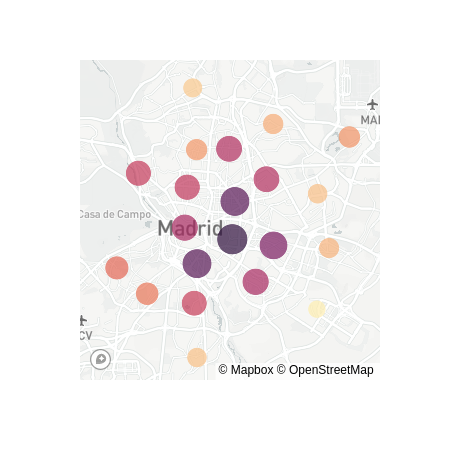

In [ ]:
print(f'The image of the path: {path_of_images[0]}')
PIL.Image.open(str(path_of_images[0]))

## Creating the dataset

### 1. Training set

In [ ]:
batch_size = 20
img_height = 33
img_width = 33
root_dir = '/content/drive/MyDrive/THESIS'
train_ds = tf.keras.utils.image_dataset_from_directory(
  root_dir,
  validation_split=0.2,
  labels=list(output['intensity']),
  subset="training",
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 151 files belonging to 1 classes.
Using 121 files for training.


In [ ]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 33, 33, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

The image_batch is a tensor of the shape (20, 33, 33, 3). This is a batch of 20 images of shape 33x33x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (20,), these are corresponding labels to the 20 images.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break ## break defined to stop printing after 1 output..

(20, 33, 33, 3)
(20,)


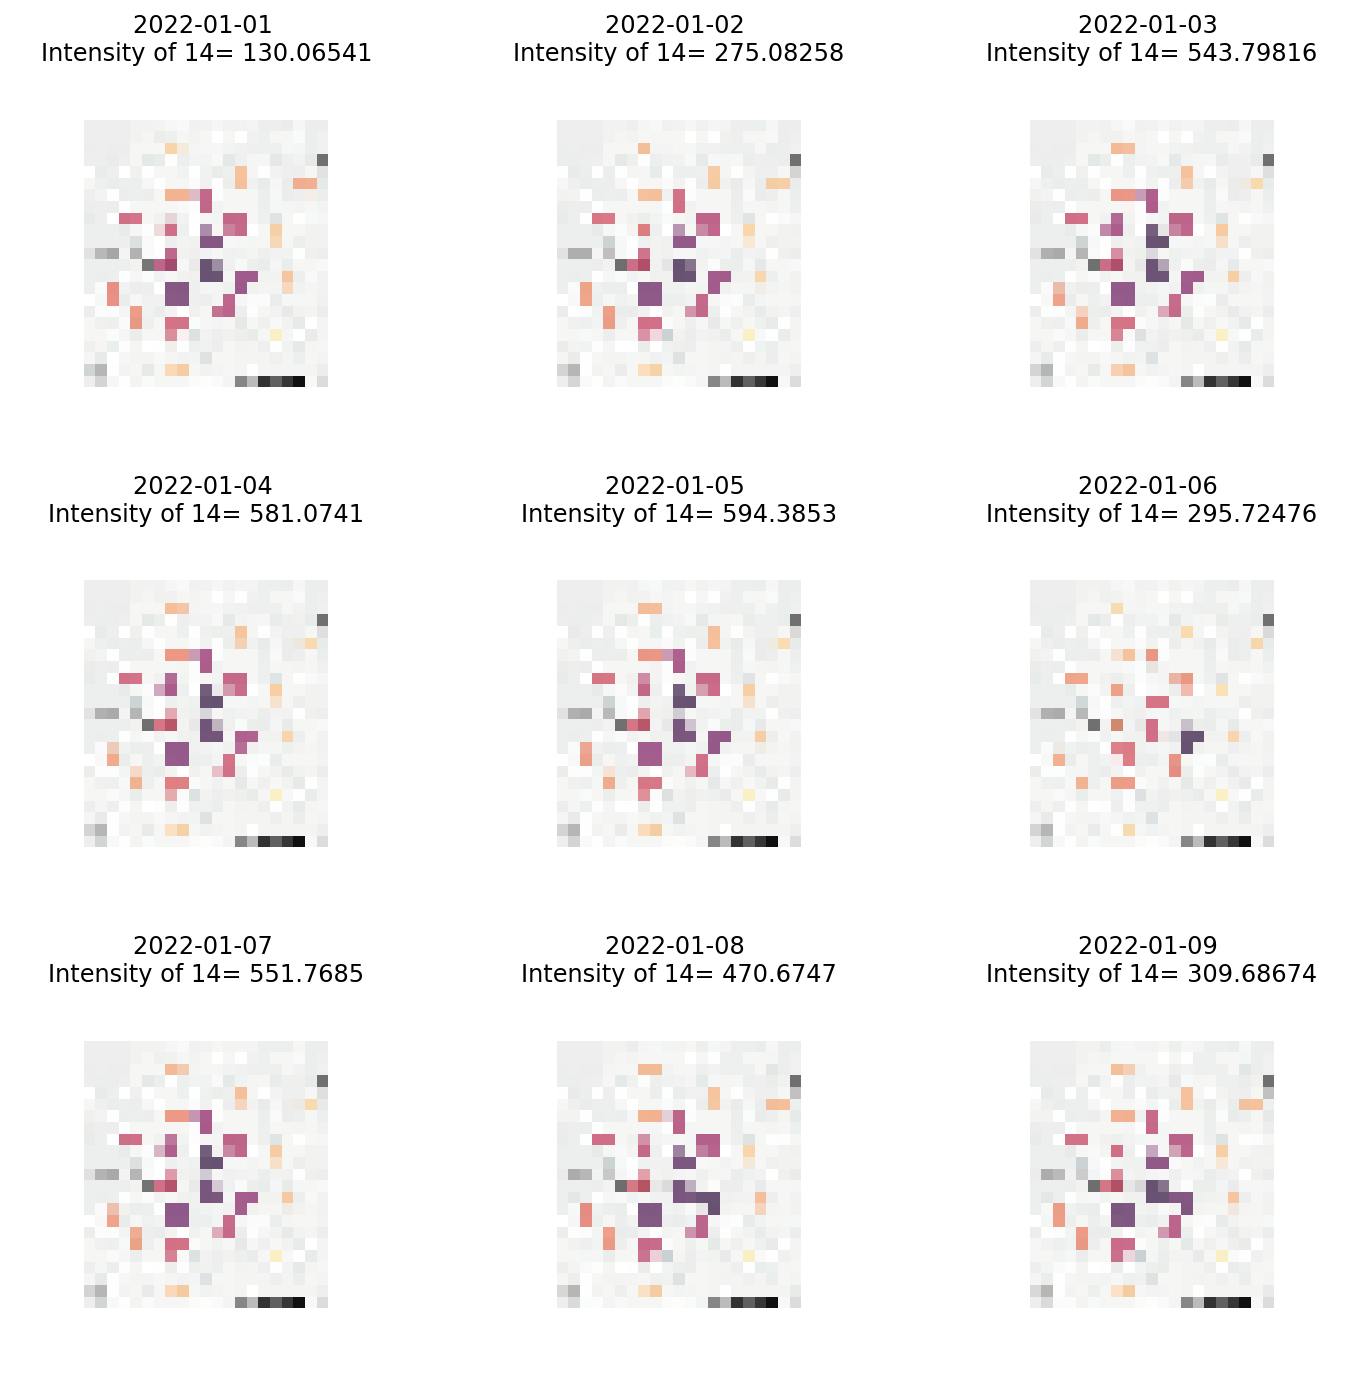

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(date_names[i] + ' \n'+'Intensity of 14= '+str(labels[i].numpy()))
    plt.axis("off")

### 2. Test set: 

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  root_dir,
  validation_split=0.2,
  labels=list(output['intensity']),
  subset="validation",
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 151 files belonging to 1 classes.
Using 30 files for validation.


In [ ]:
all_test_paths = test_ds.file_paths
date_test_list = []
for path in all_test_paths:
  path= path.split("/")[-1]
  date_test = path.partition(".")[0]
  date_test_list =np.append(date_test_list, date_test)
date_test_list

array(['2022-05-02', '2022-05-03', '2022-05-04', '2022-05-05',
       '2022-05-06', '2022-05-07', '2022-05-08', '2022-05-09',
       '2022-05-10', '2022-05-11', '2022-05-12', '2022-05-13',
       '2022-05-14', '2022-05-15', '2022-05-16', '2022-05-17',
       '2022-05-18', '2022-05-19', '2022-05-20', '2022-05-21',
       '2022-05-22', '2022-05-23', '2022-05-24', '2022-05-25',
       '2022-05-26', '2022-05-27', '2022-05-28', '2022-05-29',
       '2022-05-30', '2022-05-31'], dtype='<U32')

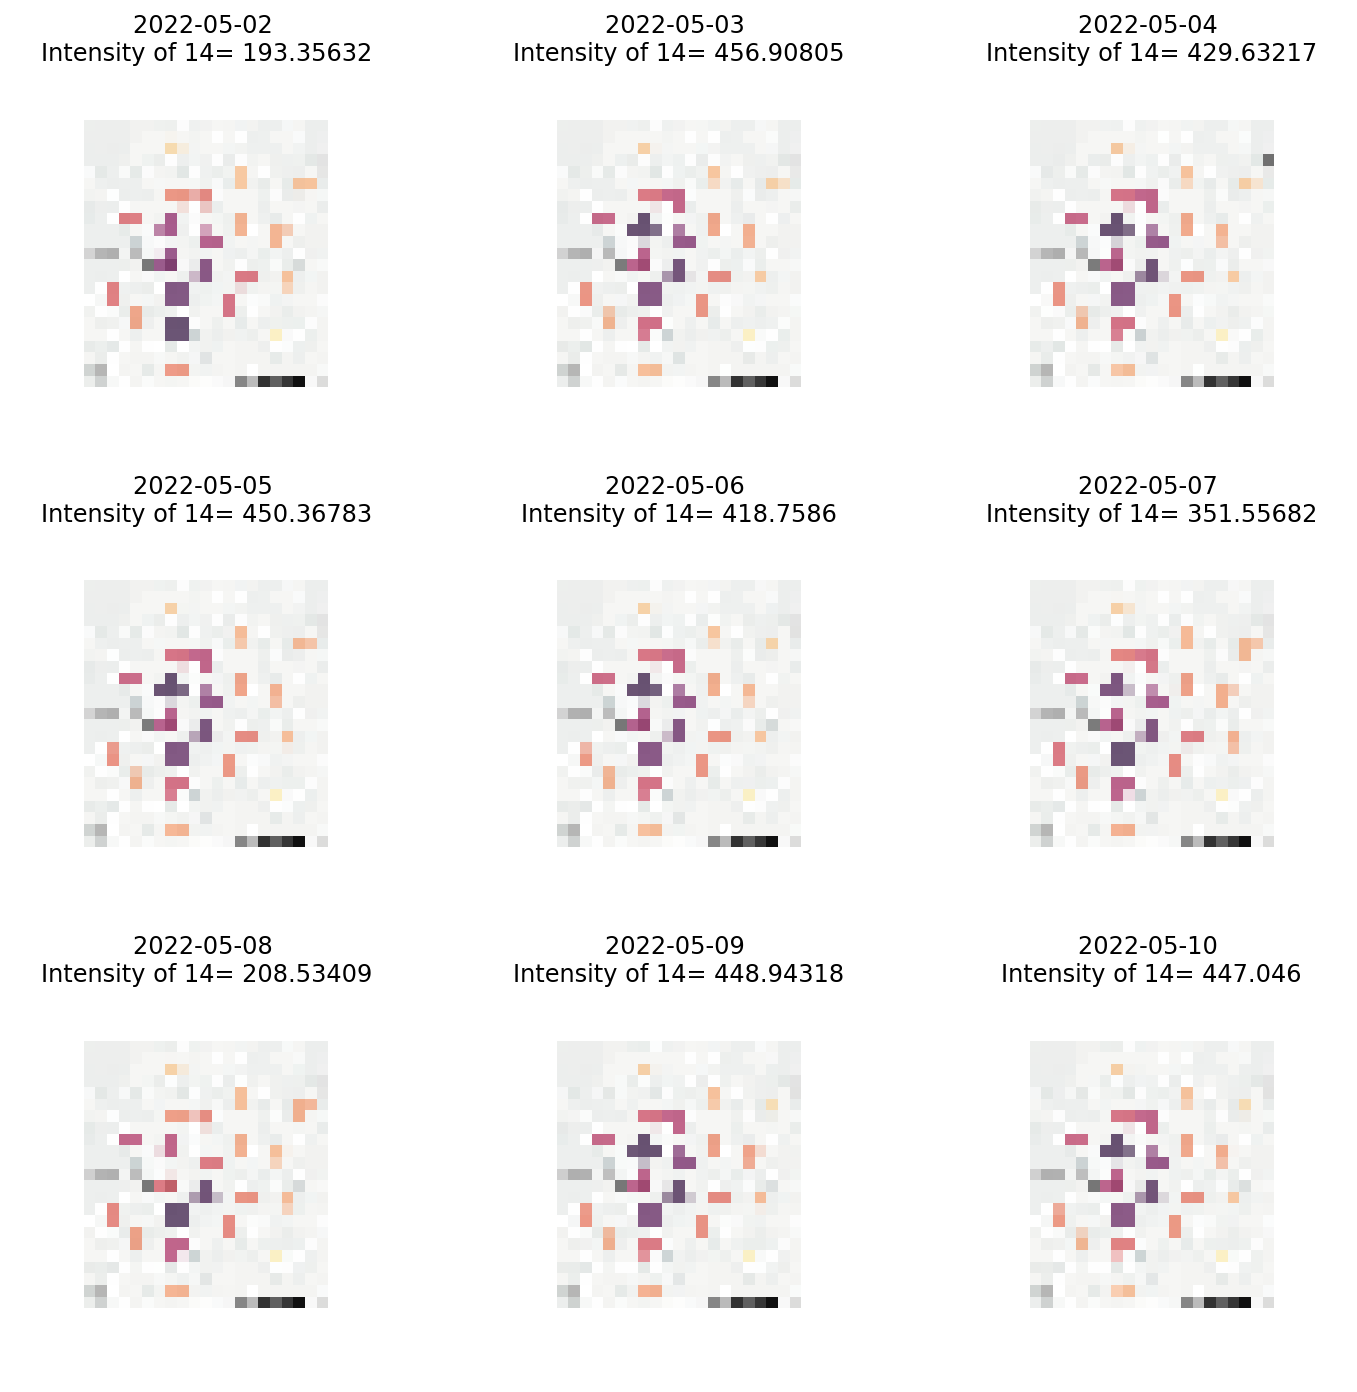

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(date_test_list[i] + ' \n'+'Intensity of 14= '+str(labels[i].numpy()))
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(20, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(20, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(20, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1) # there is only one district to predict that is 14..
])


model.compile(optimizer='adam', loss='MeanSquaredError')

In [ ]:
model.fit(
  train_ds,
  validation_data=test_ds,
  batch_size = 20,
  epochs=3
)

model.summary()

Epoch 1/3
7/7 [==============================] - 2s 141ms/step - loss: 210890.5469 - val_loss: 156776.9219
Epoch 2/3
7/7 [==============================] - 1s 138ms/step - loss: 209278.4531 - val_loss: 153267.7031
Epoch 3/3
7/7 [==============================] - 1s 129ms/step - loss: 203280.2031 - val_loss: 141898.9844
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 33, 33, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 31, 31, 20)        560       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 13, 13, 20)        3620    